Project guide: https://www.dataquest.io/m/294/guided-project%3A-exploring-ebay-car-sales-data

Solution by DataQuest: https://github.com/dataquestio/solutions/blob/master/Mission294Solutions.ipynb

In this project, which is guided by DataQuest, I will clean and analyse the used car sales data from [German eBay website's classifieds* section](https://www.ebay-kleinanzeigen.de/).

The dataset is a modified version of the original dataset - DataQuest sampled 50,000 data points out of 370000 and dirtied them. The original dataset and short descriptions of each variable (column in the dataset) are avilable [here](https://www.kaggle.com/orgesleka/used-cars-database/).


\*See https://en.wikipedia.org/wiki/Classified_advertising.

# 1. Quick glance at the data

In [1]:
# Load the data
import pandas as pd
autos = pd.read_csv("autos.csv", encoding="Latin-1")

# Show summary of dataset
print(autos.info())
print()

# Show first five rows
autos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
dateCrawled            50000 non-null object
name                   50000 non-null object
seller                 50000 non-null object
offerType              50000 non-null object
price                  50000 non-null object
abtest                 50000 non-null object
vehicleType            44905 non-null object
yearOfRegistration     50000 non-null int64
gearbox                47320 non-null object
powerPS                50000 non-null int64
model                  47242 non-null object
odometer               50000 non-null object
monthOfRegistration    50000 non-null int64
fuelType               45518 non-null object
brand                  50000 non-null object
notRepairedDamage      40171 non-null object
dateCreated            50000 non-null object
nrOfPictures           50000 non-null int64
postalCode             50000 non-null int64
lastSeen               50000 non-null obj

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50


# 2. Translate from German to English

There are columns written in German: `offerType`, `notRepairedDamage`, `seller`, `fuelType`. These will be translated into English although they will not be analysed in this project.

In [2]:
def translate(col, dic):
    autos[col] = autos[col].map(dic)
    print(autos[col].unique())

translate("offerType", {"Angebot": "Offer", "Gesuch": "Wanted"})
translate("notRepairedDamage", {"nein": "No", "ja": "Yes"})
translate("seller", {'privat': 'private', 'gewerblich': 'commercial'})
translate("fuelType", {'lpg': 'lpg',
                        'benzin': 'benzin',
                        'diesel': 'diesel',
                        'cng': 'cng',
                        'hybrid': 'hybrid',
                        'elektro': 'electro',
                        'andere': 'other'})

['Offer' 'Wanted']
['No' nan 'Yes']
['private' 'commercial']
['lpg' 'benzin' 'diesel' nan 'cng' 'hybrid' 'electro' 'other']


# 3. Convert data type

`price` and `odometer` contain numeric data, but are saved as strings due to symbol characters (`,.$`). These symbols will be removed and the columns will be converted to integer type.

Then, these columns will be renamed as `price_usd` and `odometer_km`.

In [3]:
from IPython.display import display

# To integer (price, odometer)
cols_int = ["price", "odometer"]
for col in cols_int:
    # source https://stackoverflow.com/a/22591024
    autos[col] = autos[col].str.replace("\D+", "").astype("int")

# Rename columns
cols_int_new = ["price_usd", "odometer_km"]
autos.rename(columns={k: v for k, v in zip(cols_int, cols_int_new)}, inplace=True)

# Display summary
print(autos[cols_int_new].dtypes)
display(autos[cols_int_new].head())

price_usd      int64
odometer_km    int64
dtype: object


,price_usd,odometer_km
0,5000,150000
1,8500,150000
2,8990,70000
3,4350,70000
4,1350,150000


# 4. Columns containing dates

# 4.1. Extract dates

Columns `dateCrawled`, `dateCreated` and `lastSeen` contain dates and times (e.g. "2016-03-26 17:47:46"). I will update the columns so that only dates will remain.

In [4]:
cols_dt = ["dateCrawled", "dateCreated", "lastSeen"]
for col in cols_dt:
    autos[col] = autos[col].str[:10].replace("-", "")

display(autos[cols_dt].head())

,dateCrawled,dateCreated,lastSeen
0,2016-03-26,2016-03-26,2016-04-06
1,2016-04-04,2016-04-04,2016-04-06
2,2016-03-26,2016-03-26,2016-04-06
3,2016-03-12,2016-03-12,2016-03-15
4,2016-04-01,2016-04-01,2016-04-01


# 4.2. Explore dates

As shown below, no peculiarities are observed in the three columns.

In [5]:
autos["dateCrawled"].value_counts().sort_index()

2016-03-05    1269
2016-03-06     697
2016-03-07    1798
2016-03-08    1665
2016-03-09    1661
2016-03-10    1606
2016-03-11    1624
2016-03-12    1839
2016-03-13     778
2016-03-14    1831
2016-03-15    1699
2016-03-16    1475
2016-03-17    1576
2016-03-18     653
2016-03-19    1745
2016-03-20    1891
2016-03-21    1876
2016-03-22    1647
2016-03-23    1619
2016-03-24    1455
2016-03-25    1587
2016-03-26    1624
2016-03-27    1552
2016-03-28    1742
2016-03-29    1709
2016-03-30    1681
2016-03-31    1596
2016-04-01    1690
2016-04-02    1770
2016-04-03    1934
2016-04-04    1826
2016-04-05     655
2016-04-06     159
2016-04-07      71
Name: dateCrawled, dtype: int64

In [6]:
autos["dateCreated"].value_counts().sort_index()

2015-06-11       1
2015-08-10       1
2015-09-09       1
2015-11-10       1
2015-12-05       1
2015-12-30       1
2016-01-03       1
2016-01-07       1
2016-01-10       2
2016-01-13       1
2016-01-14       1
2016-01-16       1
2016-01-22       1
2016-01-27       3
2016-01-29       1
2016-02-01       1
2016-02-02       2
2016-02-05       2
2016-02-07       1
2016-02-08       1
2016-02-09       2
2016-02-11       1
2016-02-12       3
2016-02-14       2
2016-02-16       1
2016-02-17       1
2016-02-18       2
2016-02-19       3
2016-02-20       2
2016-02-21       3
              ... 
2016-03-09    1662
2016-03-10    1593
2016-03-11    1639
2016-03-12    1831
2016-03-13     846
2016-03-14    1761
2016-03-15    1687
2016-03-16    1500
2016-03-17    1560
2016-03-18     686
2016-03-19    1692
2016-03-20    1893
2016-03-21    1886
2016-03-22    1640
2016-03-23    1609
2016-03-24    1454
2016-03-25    1594
2016-03-26    1628
2016-03-27    1545
2016-03-28    1748
2016-03-29    1707
2016-03-30  

In [7]:
autos["lastSeen"].value_counts().sort_index()

2016-03-05       54
2016-03-06      221
2016-03-07      268
2016-03-08      380
2016-03-09      493
2016-03-10      538
2016-03-11      626
2016-03-12     1191
2016-03-13      449
2016-03-14      640
2016-03-15      794
2016-03-16      822
2016-03-17     1396
2016-03-18      371
2016-03-19      787
2016-03-20     1035
2016-03-21     1037
2016-03-22     1079
2016-03-23      929
2016-03-24      978
2016-03-25      960
2016-03-26      848
2016-03-27      801
2016-03-28     1043
2016-03-29     1117
2016-03-30     1242
2016-03-31     1192
2016-04-01     1155
2016-04-02     1245
2016-04-03     1268
2016-04-04     1231
2016-04-05     6214
2016-04-06    11050
2016-04-07     6546
Name: lastSeen, dtype: int64

# 5. Improve readability of column names

# 5.1. Use more intuitive names

E.g. Rename `yearOfRegistration` as `registration_year`.

In [8]:
cols_dic = {"yearOfRegistration": "registration_year",
           "monthOfRegistration": "registration_month",
           "notRepairedDamage": "unrepaired_damage",
           "dateCreated": "ad_created"}

autos.rename(columns=cols_dic, inplace=True)
autos.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price_usd', 'abtest',
       'vehicleType', 'registration_year', 'gearbox', 'powerPS', 'model',
       'odometer_km', 'registration_month', 'fuelType', 'brand',
       'unrepaired_damage', 'ad_created', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

# 5.2. Convert camelCase to snake_case

For example, `dateCrawled` will be renamed as `date_crawled`.

In [9]:
import re

def camelCase_to_snakecase(name):
    """
    Function from https://stackoverflow.com/a/1176023
    """
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()


for i in range(len(autos.columns)):
    autos.columns.values[i] = camelCase_to_snakecase(autos.columns[i])
    
autos.columns

Index(['date_crawled', 'name', 'seller', 'offer_type', 'price_usd', 'abtest',
       'vehicle_type', 'registration_year', 'gearbox', 'power_ps', 'model',
       'odometer_km', 'registration_month', 'fuel_type', 'brand',
       'unrepaired_damage', 'ad_created', 'nr_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

# 6. Remove bad data

# 6.1. Columns with little variance

A column is not informative if most of its values are the same. These columns will be identified below.

In [10]:
# For each column
for col in autos:
    
    # Show 5 most prevalent values - unit is in percentage
    print((autos[col].value_counts(normalize=True) * 100).head(5))
    print()

2016-04-03    3.868
2016-03-20    3.782
2016-03-21    3.752
2016-03-12    3.678
2016-03-14    3.662
Name: date_crawled, dtype: float64

Ford_Fiesta            0.156
BMW_316i               0.150
Volkswagen_Golf_1.4    0.150
Volkswagen_Polo        0.144
BMW_318i               0.144
Name: name, dtype: float64

private       99.998
commercial     0.002
Name: seller, dtype: float64

Offer     99.998
Wanted     0.002
Name: offer_type, dtype: float64

0       2.842
500     1.562
1500    1.468
2500    1.286
1000    1.278
Name: price_usd, dtype: float64

test       51.512
control    48.488
Name: abtest, dtype: float64

limousine     28.636009
kleinwagen    24.099766
kombi         20.325131
bus            9.114798
cabrio         6.816613
Name: vehicle_type, dtype: float64

2000    6.708
2005    6.030
1999    6.000
2004    5.474
2003    5.454
Name: registration_year, dtype: float64

manuell      78.176247
automatik    21.823753
Name: gearbox, dtype: float64

0      11.000
75      6.342
60      4.

`seller` and `offer_type` show little variance and therefore will be removed.

In [11]:
autos.drop(["seller", "offer_type"], axis=1, inplace=True)
autos.columns

Index(['date_crawled', 'name', 'price_usd', 'abtest', 'vehicle_type',
       'registration_year', 'gearbox', 'power_ps', 'model', 'odometer_km',
       'registration_month', 'fuel_type', 'brand', 'unrepaired_damage',
       'ad_created', 'nr_of_pictures', 'postal_code', 'last_seen'],
      dtype='object')

# 6.2. Rows with wrong `registration_year`

In [12]:
print(autos["registration_year"].min())
print(autos["registration_year"].max())

1000
9999


Currently, the registration years of the advertised cars range from year 1000 to 9999. This is incorrect.

The earliest possible registration year of a car appears to be [1893, in which the world's first registration plate was introduced in France](https://en.wikipedia.org/wiki/Vehicle_registration_plate#History)

The latest possible registration year is 2016, when the last ad in the dataset was created (see below).

In [13]:
# Date on which the last ad was created
autos["ad_created"].max()

'2016-04-07'

So, I will keep only the cars whose registration years range from 1893 to 2016.

In [14]:
autos = autos.loc[autos["registration_year"].between(1893, 2016)]

# 6.3. Rows with outliers

I will check only the columns of interest: mileage (`odometer_km`) and price (`price_usd`). These columns will be briefly analysed in section `7`.

# 6.3.1. Mileage (`odometer_km`)

In [15]:
autos["odometer_km"].value_counts().sort_index()

5000        911
10000       249
20000       763
30000       769
40000       801
50000      1008
60000      1137
70000      1199
80000      1396
90000      1696
100000     2110
125000     4960
150000    31029
Name: odometer_km, dtype: int64

No peculiarity is observed.

# 6.3.2. Price (`price_usd`)

In [16]:
autos["price_usd"].value_counts().sort_index()

0           1335
1            150
2              2
3              1
5              2
8              1
9              1
10             6
11             2
12             3
13             2
14             1
15             2
17             3
18             1
20             4
25             5
29             1
30             6
35             1
40             6
45             4
47             1
49             3
50            49
55             1
59             1
60             9
65             5
66             1
            ... 
151990         1
155000         1
163500         1
163991         1
169000         1
169999         1
175000         1
180000         1
190000         1
194000         1
197000         1
198000         1
220000         1
250000         1
259000         1
265000         1
295000         1
299000         1
345000         1
350000         1
999990         1
999999         2
1234566        1
1300000        1
3890000        1
10000000       1
11111111       2
12345678      

Some cars are priced at $0. This seems incorrect.

Regarding the upper limit of the price, the car price rises rather steadily up to $1,300,000. Then, the price makes big leaps across the more expensive cars. There are only 5 of them among a total of 2,334 cars. 

So, I will include the cars priced from $1 to £1,300,000.

In [17]:
autos = autos[autos["price_usd"].between(1, 1300000)]

# 7. Analysis: Mean mileages and prices for 10 most popular brands

In this project, "popular" means "appearing most often in this dataset".

I will first aggregate data by `brand` for 10 most popular brands, and get means of `price_usd` and `odometer_km`.

In [18]:
# Identify 10 most popular brands
top_10_brands = autos["brand"].value_counts().head(10).index

agg = (autos
         .loc[autos["brand"].isin(top_10_brands)] # Select top 10 brands
         .groupby("brand")
         .agg("mean") # Get each column's mean value per brand
         .loc[:, ["price_usd", "odometer_km"]]) # Select columns of interest

agg

,price_usd,odometer_km
brand,,
audi,9336.687454,129157.386785
bmw,8571.480148,132575.905021
fiat,2813.748538,117121.971596
ford,4054.693015,124266.237745
mercedes_benz,8628.450366,130788.363313
opel,2975.241935,129310.035842
peugeot,3094.017229,127153.625269
renault,2474.864607,128071.331213
seat,4397.230950,121131.301290


Now, I will visually check how mileage and prices are related.

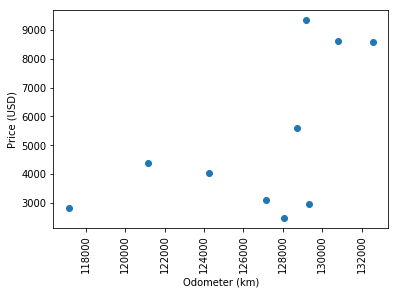

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(agg["odometer_km"], agg["price_usd"])
plt.xlabel("Odometer (km)")
plt.ylabel("Price (USD)")
plt.xticks(rotation=90)
plt.show()

Interestingly, the plot shows that cars with greater mileage might be more expensive. However, the link appears to be very weak.

I will now sort the data by the price, and display the price and mileage for each brand.

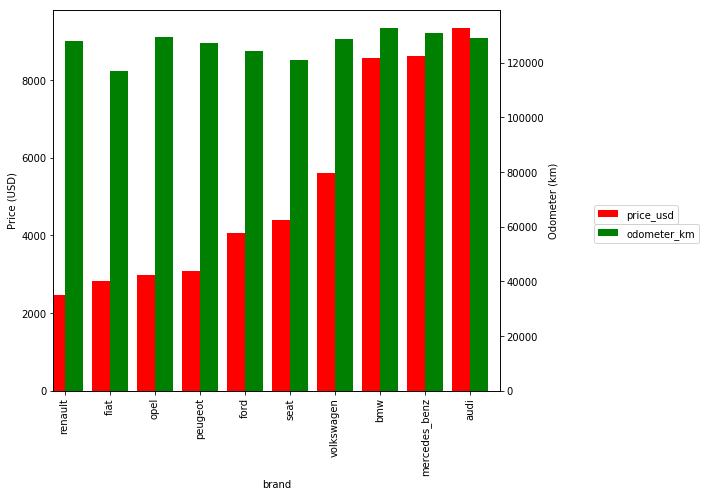

In [20]:
# Initialize plot
fig, ax1 = plt.subplots(figsize=(8, 7))
ax2 = ax1.twinx()

# Sort data by price
agg = agg.sort_values(by="price_usd")

# Draw plot
agg["price_usd"].plot(kind="bar", color="red", ax=ax1, width=0.4, position=1)
agg["odometer_km"].plot(kind="bar", color="green", ax=ax2, width=0.4, position=0)

# Show legend
# source https://stackoverflow.com/a/23556339
ax1.legend(bbox_to_anchor=(1.41, 0.5))
ax2.legend(bbox_to_anchor=(1.2, 0.45))
ax1.set_ylabel("Price (USD)")
ax2.set_ylabel("Odometer (km)")

plt.show()

Indeed, the mileage and price are not strongly correlated.

All brands display similar mileage, but the price clearly varies. A price divide is observed between the 3 most expensive brands (Auidi, Mercedes Benz and BMW) and the rest.

# 8. Closing remark

In this project, I cleaned a dataset and carried out a simple analysis.